In [71]:
import pandas as pd
import datetime as dt
import time
import requests
import pandas as pd       
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re  
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.svm import LinearSVC, SVC

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [ ]:
PROBLEM STATEMENT:

Can we use natural language processing to determine if a post on reddit came from the ask science subreddit or the personal finance subreddit? What is the most accurate model for classifying a post?

WHY IS THIS PROJECT IMPORTANT?

This project demonstrates the ability for natural language processing and machine learning models to identify the subject and content of a post on social media. 

This process can be helpful for companies that would like to monitor social media to identify which topics are trending for a given focus group. 

This project helps show which machine learning tools may be most accurate when classifying a text based post. 


DATA COLLECTION:

The function below is used for scraping data from reddit. This function uses the pushift API:

In [2]:
def query_pushshift(subreddit, kind = 'submission', day_window = 7, n = 520):
    SUBFIELDS = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments', 'score', 'is_self']
    
    # establish base url and stem
    BASE_URL = f"https://api.pushshift.io/reddit/search/{kind}" # also known as the "API endpoint" 
    stem = f"{BASE_URL}?subreddit={subreddit}&size=500" # always pulling max of 500
    
    # instantiate empty list for temp storage
    posts = []
    
    # implement for loop with `time.sleep(2)`
    for i in range(1, n + 1):
        URL = "{}&after={}d".format(stem, day_window * i)
        print("Querying from: " + URL)
        response = requests.get(URL)
        assert response.status_code == 200
        mine = response.json()['data']
        df = pd.DataFrame.from_dict(mine)
        posts.append(df)
        time.sleep(2)
        full = pd.concat(posts, sort=False)
    
    # if submission
    if kind == "submission":
        # select desired columns
        full = full[SUBFIELDS]
        # drop duplicates
        full.drop_duplicates(inplace = True)
        # select `is_self` == True
        full = full.loc[full['is_self'] == True]

    # create `timestamp` column
    full['timestamp'] = full["created_utc"].map(dt.date.fromtimestamp)
    
    print("Query Complete!")    
    return full 

The code below is used to call my querying function and scrape data from the inputted subreddit. I have commented them out with # so that when this notebook is rerun it does not spend hours scrapping new data. When I did run these functions, I saved their outputs to a csv file so I could access the data I had scraped without redoing my query.

In [3]:
#ask_science = query_pushshift("askscience")

In [4]:
#personal_finance = query_pushshift("personalfinance")

In [5]:
#ask_science.to_csv("ask_science.csv")

In [6]:
#personal_finance.to_csv("personal_finance.csv")

Below I am selecting just the first 15001 entries in each data set to use for my data analysis and model training. 

In [7]:
ask_science_df =pd.read_csv("ask_science.csv").loc[0:15_00]

In [8]:
personal_finance_df =pd.read_csv("personal_finance.csv").loc[0:15000]

In [ ]:
EDA AND CLEANING:

Below I have printed out 5 rows of my new data frames from each subreddit that I scrapped. The first is from the personal finance subreddit. The second is from the ask science subreddit.

In [10]:
personal_finance_df.head()

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,0,1couple 1single how to split rent?,I live in an apartment with one other flat mat...,personalfinance,1.611126e+09,ThenAcanthopterygii1,7,1,True,2021-01-19
1,1,The stock market isn’t only for the rich and i...,[removed],personalfinance,1.611126e+09,nouseforaname888,1,1,True,2021-01-19
2,2,Employer failed to submit my updated tax paper...,I found out yesterday that back in February 20...,personalfinance,1.611128e+09,colbysandt,21,1,True,2021-01-19
3,3,Do I need to pay taxes on Instacart/Shipt earn...,"First off, I don't need a lecture, but I forgo...",personalfinance,1.611128e+09,Objective_Elk1086,9,1,True,2021-01-19
4,4,TFSA Rules and questions-FOR A BEGINNER,"Hello,\n\nLet's just say I'm a simple, working...",personalfinance,1.611128e+09,Books000009,4,1,True,2021-01-19


In [11]:
ask_science_df.head()

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,0,How hard is it to cultivate fibroblasts or oth...,[removed],askscience,1611122557,inquilinekea,0,1,True,2021-01-19
1,1,"Covid reinfection cases seem rare, but wheneve...",[removed],askscience,1611122828,Past-Pianist,2,1,True,2021-01-19
2,2,What is the Best Way To Maintain Laptop?,[removed],askscience,1611123161,4000Sjinfotechgroup,0,1,True,2021-01-19
3,3,Can a language be learned entirely through osm...,[removed],askscience,1611123425,phreddfatt,0,1,True,2021-01-19
4,4,How would observers on earth experience lag to...,[removed],askscience,1611123478,cornelliusvanderbilt,0,1,True,2021-01-19


Below I am checking for null values in each data set. 

In [12]:
ask_science_df.isnull().sum(), personal_finance_df.isnull().sum()

(Unnamed: 0        0
 title             0
 selftext        154
 subreddit         0
 created_utc       0
 author            0
 num_comments      0
 score             0
 is_self           0
 timestamp         0
 dtype: int64,
 Unnamed: 0        0
 title             0
 selftext        171
 subreddit         0
 created_utc       0
 author            0
 num_comments      0
 score             0
 is_self           0
 timestamp         0
 dtype: int64)

In [13]:
ask_science_df.isnull().sum().sum(), personal_finance_df.isnull().sum().sum()

(154, 171)

I then dropped all rows with null values

In [14]:
ask_science_df = ask_science_df.dropna()
personal_finance_df = personal_finance_df.dropna()

Next I checked for most common values in my title and self text columns. This is to see if there are any troublsome entries that repeat and could get in the way of proper natural languae processing and prediction modeling. I found that "removed" and "deleted" was repeated in the data sets in self text.

In [15]:
from collections import Counter

In [16]:
most_common_words= [word for word, word_count in Counter(ask_science_df['title']).most_common(2)]
print(most_common_words)
#cite https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list

['Ask Anything Wednesday - Physics, Astronomy, Earth and Planetary Science', 'Ask Anything Wednesday - Economics, Political Science, Linguistics, Anthropology']


In [17]:
most_common_words= [word for word, word_count in Counter(ask_science_df['selftext']).most_common(2)]
print(most_common_words)

['[removed]', '\\[removed\\]']


In [18]:
most_common_words= [word for word, word_count in Counter(personal_finance_df['title']).most_common(2)]
print(most_common_words)

['Should I buy a house?', 'How am I doing?']


In [19]:
most_common_words= [word for word, word_count in Counter(personal_finance_df['selftext']).most_common(2)]
print(most_common_words)

['[removed]', '[deleted]']


Next, I check how often "removed" is an input in the data sets for self text and for title. I find "removed" is the imput for the majority of the entries for self text in the ask science data frame.  I believe this is because in ask science the posts are phrased as a question which can be fully articulated in just the title of the reddit post. I will not be using the selftext feature in my analysis due to the findings here and will instead focus on classifying my entries based on the title text of the posts. 

In [20]:
removed_text_counter  = 0
for i in personal_finance_df.loc[personal_finance_df['title']=='[removed]'].index:
    removed_text_counter  += 1
print(removed_text_counter )
    

0


In [21]:
removed_text_counter  = 0
for i in personal_finance_df.loc[personal_finance_df['selftext']=='[removed]'].index:
    removed_text_counter  += 1
print(removed_text_counter )

1782


In [102]:
removed_text_counter  = 0
for i in ask_science_df.loc[ask_science_df['title']=='[removed]'].index:
    removed_text_counter  += 1
print(removed_text_counter )
    

0


In [23]:
removed_text_counter = 0
for i in ask_science_df.loc[ask_science_df['selftext']=='[removed]'].index:
    removed_text_counter  += 1
print(removed_text_counter )

14611


Next I wrote a function to add a column in each dataframe which classifies where each post came from. This calssifier will be used to train and test my data for modeling. I calssified the ask science subreddit as 0 and  the personal finance reddit as 1.

In [25]:
#ask science reddit is 0
for i in ask_science_df['title']:
    ask_science_df['subreddit'] = 0


In [27]:
#Personal Finance reddit is 1
for i in personal_finance_df['title']:
    personal_finance_df['subreddit'] = 1

Next I stacked the two data frames on top of each other and created on large master data frame. I also dropped the column "Unnamed: 0".

In [29]:
df_all = pd.concat([ask_science_df, personal_finance_df], axis = 0) 

In [30]:
df_all.shape

(29677, 10)

In [31]:
df_all.drop(columns = ["Unnamed: 0"], inplace = True)

PREPROCESSING AND MODELING

Set my X and y variables. My X variable is the title text. My y variable is the subreddit that the text came from.

In [140]:
X = df_all["title"]
y = df_all["subreddit"]

Next I run my train test split and count vectorizer. Then I fit and transform training data with my count vectorizer. 

In [141]:
X_train_cvec, X_test_cvec, y_train_cvec, y_test_cvec = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [142]:
cvec = CountVectorizer(stop_words='english')

In [143]:
# Fit the vectorizer on our corpus.
X_train_cvec = cvec.fit_transform(X_train_cvec)

In [144]:
# Transform the corpus.
X_test_cvec = cvec.transform(X_test_cvec)

Next I print out the most common words in each dataset and also in the combined dataset. 

In [134]:
ask_science_cvec= cvec.fit_transform(ask_science_df["title"])

In [125]:
personal_finance_cvec= cvec.fit_transform(personal_finance_df["title"])

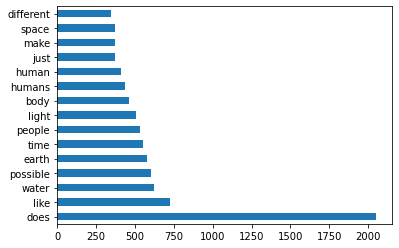

In [135]:
# convert training data to dataframe
ask_science_df_2 = pd.DataFrame(ask_science_cvec.todense(), 
                          columns=cvec.get_feature_names())

# plot top occuring words
ask_science_df_2.sum().sort_values(ascending=False).head(15).plot(kind='barh');

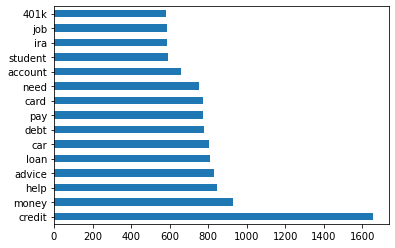

In [106]:
# convert training data to dataframe
personal_finance_df_2 = pd.DataFrame(personal_finance_cvec.todense(), 
                          columns=cvec.get_feature_names())

# plot top occuring words
personal_finance_df_2.sum().sort_values(ascending=False).head(15).plot(kind='barh');

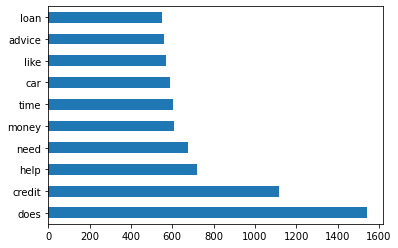

In [146]:
# convert training data to dataframe
X_train_df = pd.DataFrame(X_train_cvec.todense(), 
                          columns=cvec.get_feature_names())

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

Next I check the null model values to get my baseline score.

In [38]:
y_test_cvec.value_counts(normalize=True)

0    0.500306
1    0.499694
Name: subreddit, dtype: float64

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

My first model is my Niave Bayes model. I set up a pipeline and grid search to find optimized values for my model. I will fit my model and then score my model based on the accuracy score specifically. I will also print out other supporting statistics to contextualize my model's predictive capabilities. 

In [40]:
pipe = Pipeline([
    ('cvec_2', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [41]:
pipe_params = {
    'cvec_2__max_features': [2000, 3000, 4000, 5000],
    'cvec_2__min_df': [2, 3],
    'cvec_2__max_df': [.9, .95],
    'cvec_2__ngram_range': [(1,1), (1,2)]
}

In [42]:
# Instantiate GridSearchCV.

bayes_model = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1) # 5-fold cross-validation.

In [43]:
bayes_model.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec_2', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec_2__max_df': [0.9, 0.95],
                         'cvec_2__max_features': [2000, 3000, 4000, 5000],
                         'cvec_2__min_df': [2, 3],
                         'cvec_2__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [44]:
bayes_model.score(X_train, y_train), bayes_model.score(X_test, y_test)

(0.9724890610068903, 0.9714110680008168)

In [45]:
preds_bayes = bayes_model.predict(X_test)


In [46]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_bayes).ravel()

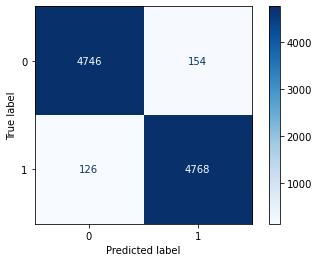

In [47]:
plot_confusion_matrix(bayes_model, X_test, y_test, cmap='Blues', values_format='d');

In [48]:
acc = (tn + tp)/(tn+tp+fn+fp)
print('Accuracy:', acc)
spec = tn / (tn + fp)
print('Specificity:', spec)
prec = tp / (tp+fp) # precision_score(y_test, preds)
print('Precision:', prec)
sens = tp/(tp+fn) # recall_score(y_test,preds)
print('Sensitivity:', sens)
tpr = sens
print('TPR:', sens)
fpr = fp / (fp + tn)
print('FPR:', fpr)
f1 = 2*(prec*sens)/(prec+sens) # f1_score(y_test, preds)
print('F1:', f1)
bayes_model.best_params_
bayes_model.best_estimator_
#cite cooper on this codebay

Accuracy: 0.9714110680008168
Specificity: 0.9685714285714285
Precision: 0.9687119057293783
Sensitivity: 0.9742541888026155
TPR: 0.9742541888026155
FPR: 0.03142857142857143
F1: 0.9714751426242869


Pipeline(steps=[('cvec_2',
                 CountVectorizer(max_df=0.9, max_features=5000, min_df=3)),
                ('nb', MultinomialNB())])

My second model is an Ada Boost Classifier. I set up a grid search to find optimized values for my model. I will fit my model and then score my model based on the accuracy score specifically. I will also print out other supporting statistics to contextualize my model's predictive capabilities. 

In [49]:
ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier()
)

ada_params = {"n_estimators": [50,100],
              "base_estimator__max_depth": [1,2],
              "learning_rate" : [0.9, 1]}

# instantiate gridsearch object
ada_model = GridSearchCV(ada,                      # model object
                  param_grid= ada_params,   # hyper parameters
                  cv = 3)                   # cv is number of folds



In [50]:
ada_model.fit(X_train_cvec, y_train_cvec)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             param_grid={'base_estimator__max_depth': [1, 2],
                         'learning_rate': [0.9, 1], 'n_estimators': [50, 100]})

In [51]:
ada_model.score(X_train_cvec, y_train_cvec), ada_model.score(X_test_cvec, y_test_cvec)

(0.9262686717296182, 0.9232182969164795)

In [52]:
preds_ada = ada_model.predict(X_test_cvec)

In [53]:
tn, fp, fn, tp = confusion_matrix(y_test_cvec, preds_ada).ravel()

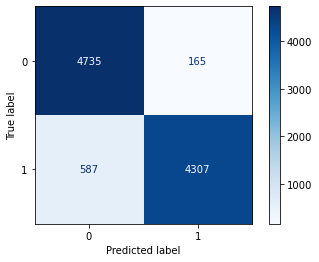

In [54]:
plot_confusion_matrix(ada_model, X_test_cvec, y_test_cvec, cmap='Blues', values_format='d');

In [55]:
acc = (tn + tp)/(tn+tp+fn+fp)
print('Accuracy:', acc)
spec = tn / (tn + fp)
print('Specificity:', spec)
prec = tp / (tp+fp) # precision_score(y_test, preds)
print('Precision:', prec)
sens = tp/(tp+fn) # recall_score(y_test,preds)
print('Sensitivity:', sens)
tpr = sens
print('TPR:', sens)
fpr = fp / (fp + tn)
print('FPR:', fpr)
f1 = 2*(prec*sens)/(prec+sens) # f1_score(y_test, preds)
print('F1:', f1)
ada_model.best_params_
ada_model.best_estimator_
#cite cooper on this codebay

Accuracy: 0.9232182969164795
Specificity: 0.9663265306122449
Precision: 0.9631037567084079
Sensitivity: 0.8800572129137719
TPR: 0.8800572129137719
FPR: 0.0336734693877551
F1: 0.9197095878710229


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=1, n_estimators=100)

My third model is a Gradient Boost Classifier. I set up a grid search to find optimized values for my model. I will fit my model and then score my model based on the accuracy score specifically. I will also print out other supporting statistics to contextualize my model's predictive capabilities. 

In [56]:
# GBM model
# instantiate
gboost = GradientBoostingClassifier()  # NOTE: the base learner is ALWAYS a decision tree (default)
# grid for Grid search
gboost_params = {"max_depth": [2,3,4],
                 "n_estimators": [100, 125, 150],
                 "learning_rate": [0.08, 0.1, 0.12]}
# instantiate the grid search object
gradient_boost_model = GridSearchCV(gboost, 
                     param_grid = gboost_params, 
                     cv=3)
gradient_boost_model.fit(X_train_cvec, y_train_cvec)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.08, 0.1, 0.12],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [100, 125, 150]})

In [57]:
gradient_boost_model.score(X_train_cvec, y_train_cvec), gradient_boost_model.score(X_test_cvec, y_test_cvec)

(0.8987074385153145, 0.9004492546457015)

In [58]:
preds_gradient_boost = gradient_boost_model.predict(X_test_cvec)

In [59]:
tn, fp, fn, tp = confusion_matrix(y_test_cvec, preds_gradient_boost).ravel()

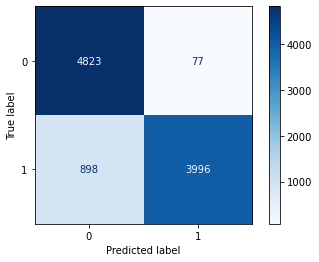

In [60]:
plot_confusion_matrix(gradient_boost_model, X_test_cvec, y_test_cvec, cmap='Blues', values_format='d');

In [61]:
acc = (tn + tp)/(tn+tp+fn+fp)
print('Accuracy:', acc)
spec = tn / (tn + fp)
print('Specificity:', spec)
prec = tp / (tp+fp) # precision_score(y_test, preds)
print('Precision:', prec)
sens = tp/(tp+fn) # recall_score(y_test,preds)
print('Sensitivity:', sens)
tpr = sens
print('TPR:', sens)
fpr = fp / (fp + tn)
print('FPR:', fpr)
f1 = 2*(prec*sens)/(prec+sens) # f1_score(y_test, preds)
print('F1:', f1)
ada_model.best_params_
ada_model.best_estimator_

Accuracy: 0.9004492546457015
Specificity: 0.9842857142857143
Precision: 0.9810950159587528
Sensitivity: 0.81651001225991
TPR: 0.81651001225991
FPR: 0.015714285714285715
F1: 0.8912679826028773


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=1, n_estimators=100)

My fourth model is a second Niave Bayes model with new parameters. I set up a pipeline and grid search to find optimized values for my model. I will fit my model and then score my model based on the accuracy score specifically. I will also print out other supporting statistics to contextualize my model's predictive capabilities. 

In [62]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [63]:

# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [64]:
# Instantiate GridSearchCV.

tvec_model = GridSearchCV(pipe_tvec, # what object are we optimizing?
                        param_grid = pipe_tvec_params, # what parameters values are we searching?
                        cv=5) # 5-fold cross-validation.

In [65]:
tvec_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [147]:
tvec_model.score(X_train, y_train), tvec_model.score(X_test, y_test)

(0.9756073027209173, 0.9715131713293853)

In [67]:
preds_tvec = tvec_model.predict(X_test)


In [68]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

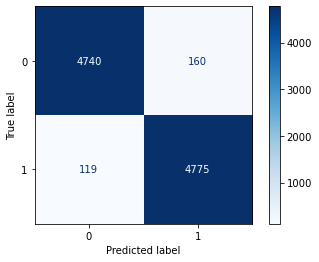

In [69]:
plot_confusion_matrix(tvec_model, X_test, y_test, cmap='Blues', values_format='d');

In [70]:
acc = (tn + tp)/(tn+tp+fn+fp)
print('Accuracy:', acc)
spec = tn / (tn + fp)
print('Specificity:', spec)
prec = tp / (tp+fp) # precision_score(y_test, preds)
print('Precision:', prec)
sens = tp/(tp+fn) # recall_score(y_test,preds)
print('Sensitivity:', sens)
tpr = sens
print('TPR:', sens)
fpr = fp / (fp + tn)
print('FPR:', fpr)
f1 = 2*(prec*sens)/(prec+sens) # f1_score(y_test, preds)
print('F1:', f1)
ada_model.best_params_
ada_model.best_estimator_

Accuracy: 0.9715131713293853
Specificity: 0.9673469387755103
Precision: 0.9675785207700102
Sensitivity: 0.9756845116469146
TPR: 0.9756845116469146
FPR: 0.0326530612244898
F1: 0.9716146098280599


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=1, n_estimators=100)

My final model is an SVC Model. I set up a grid search to find optimized values for my model. I will fit my model and then score my model based on the accuracy score specifically. I will also print out other supporting statistics to contextualize my model's predictive capabilities. 

In [96]:
SVC_params= {"C": [1, 10, 100],
                 "kernel": ["rbf", "poly"],
                 "gamma": ["scale", "auto"]
}

In [97]:
svc_model = GridSearchCV(SVC(), # what object are we optimizing?
                        param_grid = SVC_params, # what parameters values are we searching?
                        cv=5) # 5-fold cross-validation.

In [83]:
# Instantiate SVM.
svc_test_model = SVC(
    C = 10,
    kernel = ["rbf"],
    gamma = "scale"
)

# Fit on training data.
#svc_model.fit(X_train, y_train)

# Evaluate model.
#accuracy_score(y_test, svc.predict(X_test))

In [98]:
svc_model.fit(X_train_cvec, y_train_cvec)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly']})

In [99]:
svc_model.score(X_train_cvec, y_train_cvec), svc_model.score(X_test_cvec, y_test_cvec)

(0.9988935271337324, 0.959464978558301)

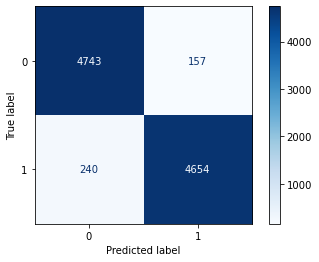

In [101]:
plot_confusion_matrix(svc_model, X_test_cvec, y_test_cvec, cmap='Blues', values_format='d')

CONCLUSIONS AND RECOMENDATIONS:

In this project I found that we can use natural language processing to determine if a post on reddit came from the ask science subreddit or the personal finance subreddit with 97.1% accuracy on unseen data. 

I found the most accurate model for classifying a posts source to be a Naive Bayes model.

For companies trying monitor social media to identify which topics are trending for a given focus group, I recommend using a Naive Bayes model for classification
If a Naive Bayes model is not getting an ideal accuracy score, I recommend also trying the runner up model, SVC.
